Install and import necesseary libraries, frameworks 

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt 

Load train and test data as pandas DataFrames

In [ ]:
train_df = pd.read_csv('train.csv',na_filter=False)

Drop 'id' columns because it does not provide meaningful data to predict the calorie expenditure. Its being will cause faults when traning and testing the NN.

In [ ]:
train_df.drop(columns='id',inplace=True)

Processing data for model training looking for NaN values on the dataset and handling them, dropping unnecesseary columns, transform data and split data to test and train splits

In [34]:
def process_data(dataframe):
    if dataframe.isna().sum().sum() > 0 or dataframe.isnull().sum().sum() > 0:
        dataframe.dropna
    
    X = dataframe.drop(columns='Calories')
    Y = dataframe['Calories']
    
    numeric_features = ['Age','Height','Weight','Heart_Rate','Body_Temp']
    categorical_features = ['Sex']
    
    num_encoder = StandardScaler()
    cat_encoder = OneHotEncoder(drop="first", sparse_output=False)
    
    preprocessor = ColumnTransformer(transformers= [('num', num_encoder, numeric_features),('cat',cat_encoder,categorical_features)])
    
    X_precessed = preprocessor.fit_transform(X)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_precessed, Y , test_size=0.25, random_state=42)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    return X_train, X_test, Y_train, Y_test
    

In [35]:
X_train, X_test, Y_train, Y_test = process_data(train_df)

X_train shape: (562500, 6)
X_test shape: (187500, 6)


Building Neural Network for regression traning using ReLu for activation function, optimized with adam optimizer and used a MSE for the loss function 

In [39]:
def create_model(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                  loss='mean_squared_error', 
                  metrics=[keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None), 
                  keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)
                  ])
    
    model.summary()
    
    return model

In [40]:
model = create_model(X_train.shape[1])

/home/albatrosfirst/calorieexp_NN/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1746617068.633150    1689 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746617068.850269    1689 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 192 (768.00 B)

Defining train_model function this function accepts model and traning and test data splits, creates a callback object of keras EarlyStopping class restore to the best paramaters on while traning to acces the best trarning epochs. Configuring model trainig with train data splits, batch sizes and validation data and returning model and traning history of the epochs results.

In [45]:
def train_model(model, x_train, x_test, y_train, y_test):
    callback = keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=5, 
        restore_best_weights=True
        )
    
    traning = model.fit(x= x_train,
              y= y_train,
              epochs= 100,
              callbacks= [callback],
              batch_size= 64,
              validation_data= (x_test, y_test),
              )
    
    return model, traning

In [47]:
trained_model,training = train_model(model, X_train, X_test, Y_train, Y_test)

Epoch 1/100
8790/8790 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 217.6876 - mean_absolute_error: 10.7235 - mean_squared_error: 217.6876 - val_loss: 181.3868 - val_mean_absolute_error: 9.7507 - val_mean_squared_error: 181.3868
Epoch 2/100
8790/8790 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - loss: 215.7873 - mean_absolute_error: 10.6510 - mean_squared_error: 215.7873 - val_loss: 182.0086 - val_mean_absolute_error: 9.8358 - val_mean_squared_error: 182.0086
Epoch 3/100
8790/8790 ━━━━━━━━━━━━━━━━━━━━ 90s 10ms/step - loss: 214.4155 - mean_absolute_error: 10.6327 - mean_squared_error: 214.4155 - val_loss: 182.7892 - val_mean_absolute_error: 9.8464 - val_mean_squared_error: 182.7892
Epoch 4/100
8790/8790 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - loss: 212.2582 - mean_absolute_error: 10.5865 - mean_squared_error: 212.2582 - val_loss: 182.5332 - val_mean_absolute_error: 9.8672 - val_mean_squared_error: 182.5332
Epoch 5/100
8790/8790 ━━━━━━━━━━━━━━━━━━━━ 144s 16ms/step - loss: 210.3065 - mean_absolute_error

Defening and measuring the model outputs according to test splits to measure how well the model is trained we are measuring the Mean Squared Error between predictions and the real outputs, Mean Absolute Error, Root of the MSE and lastly the R2 score to evaluate the overall quality of the model.

In [38]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    rmse = np.sqrt(mse)
    
    print("Model evaluations:\n")
    print(f"Mean Squared Error: {mse}\n")
    print(f"Mean Absolute Error: {mae}\n")
    print(f"R2 Score: {r2}\n")
    print(f"Root Mean Squared Error: {rmse}\n")
    

In [52]:
evaluate_model(model, X_test, Y_test)

5860/5860 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step
Model evaluations:

Mean Squared Error: 197.32586705354754

Mean Absolute Error: 10.626487284851073

R2 Score: 0.9491136793202063

Root Mean Squared Error: 14.047272584154816



Above results indicate a very well output score of %94.9 R2 score this means model explains the calorie expenditure with %95 of variance its a very good score for the first and raw traning we have done, RMSE is 14.05 this indicates model predicts calories larger than the true expenditure and lastly MAE is 10.62 directly indicates the absolute difference avg between prediction to truth. 
Now lets try to upgrade this model to a more advanced version for reducing the error scores.

**Feature Engineering**

On the above cells we use the data as given we did not create any meaninful columns combining what we have on the data we can populate the columns with what data we have examples:

***1.BMI(weight/height^2)***

Measures a persons Body Mass Index indicates if a personis underweight, normal, overweight or obese. This measurement can give us a deeper understanding for calorie predictions.

***2.Calorie Rate(calorie/duration)***

Colorie expenditure per duration.

***3.Temp adjusted heart rate***

High body temp can increase hearth rate this can indicate more calorie expenditure than nromal parameters normalizing this to 37 degrees can give us reduced calori exp.

In [4]:
def process_data_with_features(dataframe):
    if dataframe.isna().sum().sum() > 0 or dataframe.isnull().sum().sum() > 0:
        dataframe.dropna
    
    dataframe['BMI'] = dataframe['Weight'] / ((dataframe['Height']/100) ** 2)
    dataframe['Calorie_Rate'] = dataframe['Calories'] / dataframe['Duration']
    dataframe['Adjusted_HR'] = dataframe['Heart_Rate'] * (37/dataframe['Body_Temp'])
    
    X = dataframe.drop(columns='Calories')
    Y = dataframe['Calories']
    
    numeric_features = ['Age','Height','Weight','Heart_Rate','Body_Temp','BMI','Calorie_Rate','Adjusted_HR']
    categorical_features = ['Sex']
    
    num_encoder = StandardScaler()
    cat_encoder = OneHotEncoder(drop="first", sparse_output=False)
    
    preprocessor = ColumnTransformer(transformers= [('num', num_encoder, numeric_features),('cat',cat_encoder,categorical_features)])
    
    X_precessed = preprocessor.fit_transform(X)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_precessed, Y , test_size=0.25, random_state=42)
    
    print(f"X_train_enh shape: {X_train.shape}")
    print(f"X_test_enh shape: {X_test.shape}")
    
    return X_train, X_test, Y_train, Y_test
    

In [5]:
X_train_enh, X_test_enh, Y_train_enh, Y_test_enh = process_data_with_features(train_df)

X_train_enh shape: (562500, 9)
X_test_enh shape: (187500, 9)


***Enhance Model Architecture***

Compiling a more deep layered Neural Network with deeper layers and with different loss function to increase prediction accuracy. This enhanced model uses Huber loss function that combines MSE and MAE loss function.

In [6]:
def advanced_model_building(input_shape):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(96, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                  loss= keras.losses.Huber(delta=1.0), 
                  metrics=[keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None), 
                  keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)
                  ])
    
    model.summary()
    
    return model

In [7]:
enhanced_model = advanced_model_building(X_train_enh.shape[1])

/home/albatrosfirst/calorieexp_NN/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1746642557.976555    1488 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746642557.978119    1488 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,777 (92.88 KB)

 Trainable params: 23,137 (90.38 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
def train_enhanced_model(model, x_train, x_test, y_train, y_test):
    callbacks = [keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
    'best_param_model.h5',
    monitor='val_loss',
    save_best_only=True,    
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patiance=5,
    min_lr=1e-6,
    )]
    
    traning = model.fit(x= x_train,
              y=y_train,
              epochs= 3,
              callbacks=[callbacks],
              batch_size=32,
              validation_data=(x_test, y_test),
              verbose=1
              )
    
    return model, traning

***Model Traning***

Advanced Model traning callbacks to maximize traning efficiency.

**1.Early Stopping**

Monitors the validation loss to between 10 epochs and stops the traning if the validation loss metrics is not improving to stop over traning.

**2.Model Check Point**

Also validation loss metrics and saves the best parameter model of the whole traning session

**3.Reduce Learning Rate**

This callback reduces the model learning rate by the factor of 0.2 when the learning stagnated between 5 epochs. This reduction helps model to train faster and accurately as we getting closer to the solution of the learning steps are getting smaller thus more accurate


In [11]:
trained_enhanced_model, enhanced_model_traning = train_enhanced_model(enhanced_model, X_train_enh, X_test_enh, Y_train_enh, Y_test_enh)

Epoch 1/150
17578/17579 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 8.8639 - mean_absolute_error: 9.3456 - mean_squared_error: 177.5521

17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1146s 65ms/step - loss: 8.8639 - mean_absolute_error: 9.3456 - mean_squared_error: 177.5520 - val_loss: 8.6122 - val_mean_absolute_error: 9.0945 - val_mean_squared_error: 179.2811 - learning_rate: 2.0000e-04
Epoch 2/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1133s 64ms/step - loss: 8.7996 - mean_absolute_error: 9.2812 - mean_squared_error: 175.4185 - val_loss: 8.9144 - val_mean_absolute_error: 9.3961 - val_mean_squared_error: 180.5651 - learning_rate: 2.0000e-04
Epoch 3/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1115s 63ms/step - loss: 8.8007 - mean_absolute_error: 9.2820 - mean_squared_error: 175.5781 - val_loss: 8.6785 - val_mean_absolute_error: 9.1603 - val_mean_squared_error: 181.2481 - learning_rate: 2.0000e-04
Epoch 4/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1048s 60ms/step - loss: 8.7805 - mean_absolute_error: 9.2617 - mean_squared_error: 174.9657 - val_loss: 8.6573 - val_mean_absolute_error: 9.1383 - val_mean_squared_error: 171.8458 - learning_rate: 2.0000e-04


17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1051s 60ms/step - loss: 8.7900 - mean_absolute_error: 9.2715 - mean_squared_error: 175.4336 - val_loss: 8.5445 - val_mean_absolute_error: 9.0260 - val_mean_squared_error: 179.0274 - learning_rate: 2.0000e-04
Epoch 6/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1062s 60ms/step - loss: 8.7891 - mean_absolute_error: 9.2704 - mean_squared_error: 175.4587 - val_loss: 8.7408 - val_mean_absolute_error: 9.2227 - val_mean_squared_error: 174.2221 - learning_rate: 2.0000e-04
Epoch 7/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1039s 59ms/step - loss: 8.7838 - mean_absolute_error: 9.2650 - mean_squared_error: 175.3087 - val_loss: 8.6446 - val_mean_absolute_error: 9.1265 - val_mean_squared_error: 176.8924 - learning_rate: 2.0000e-04
Epoch 8/150
17579/17579 ━━━━━━━━━━━━━━━━━━━━ 1088s 62ms/step - loss: 8.7937 - mean_absolute_error: 9.2751 - mean_squared_error: 174.9301 - val_loss: 8.6555 - val_mean_absolute_error: 9.1380 - val_mean_squared_error: 177.0409 - learning_rate: 2.0000e-04


In [39]:
evaluate_model(trained_enhanced_model, X_test_enh, Y_test_enh)

5860/5860 ━━━━━━━━━━━━━━━━━━━━ 224s 35ms/step
Model evaluations:

Mean Squared Error: 179.0273569381478

Mean Absolute Error: 9.025999050083795

R2 Score: 0.9538324922543565

Root Mean Squared Error: 13.380110497979745



***Evaluation***

As we on the evaluation scores enhanced model performed better with %95.4 R^2 score and MAE of 9 these scores were %94.6 and 10.6 on the previous model respectively. 

MSE goes down from 197.3 to 179.0 and RMSE from 14.0 to 13.3.

In [55]:
def plot_traning_session(traning_history):
    plt.Figure(figsize=(24,24))
    
    plt.subplot(1,2,1)
    plt.plot(traning_history.history['loss'])
    plt.plot(traning_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

***Plotting the Traning sessions Loss vs Epoch***

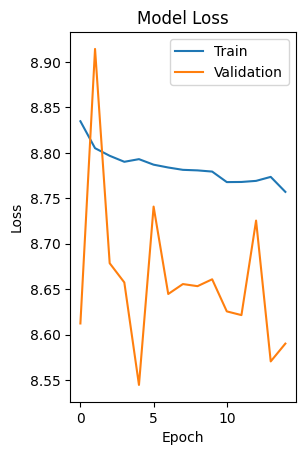

In [56]:
plot_traning_session(enhanced_model_traning)

In [62]:
def plot_predictions(model,x_test, y_test):
    plt.figure(figsize=(20, 12))
    
    y_pred = model.predict(x_test)
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    max_val = max(np.max(y_test), np.max(y_pred))
    min_val = min(np.min(y_test), np.min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title('Actual vs Predicted Calories')
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.tight_layout()
    plt.show()

***Plotting Actual Colarie vs Predicted***

5860/5860 ━━━━━━━━━━━━━━━━━━━━ 86s 14ms/step


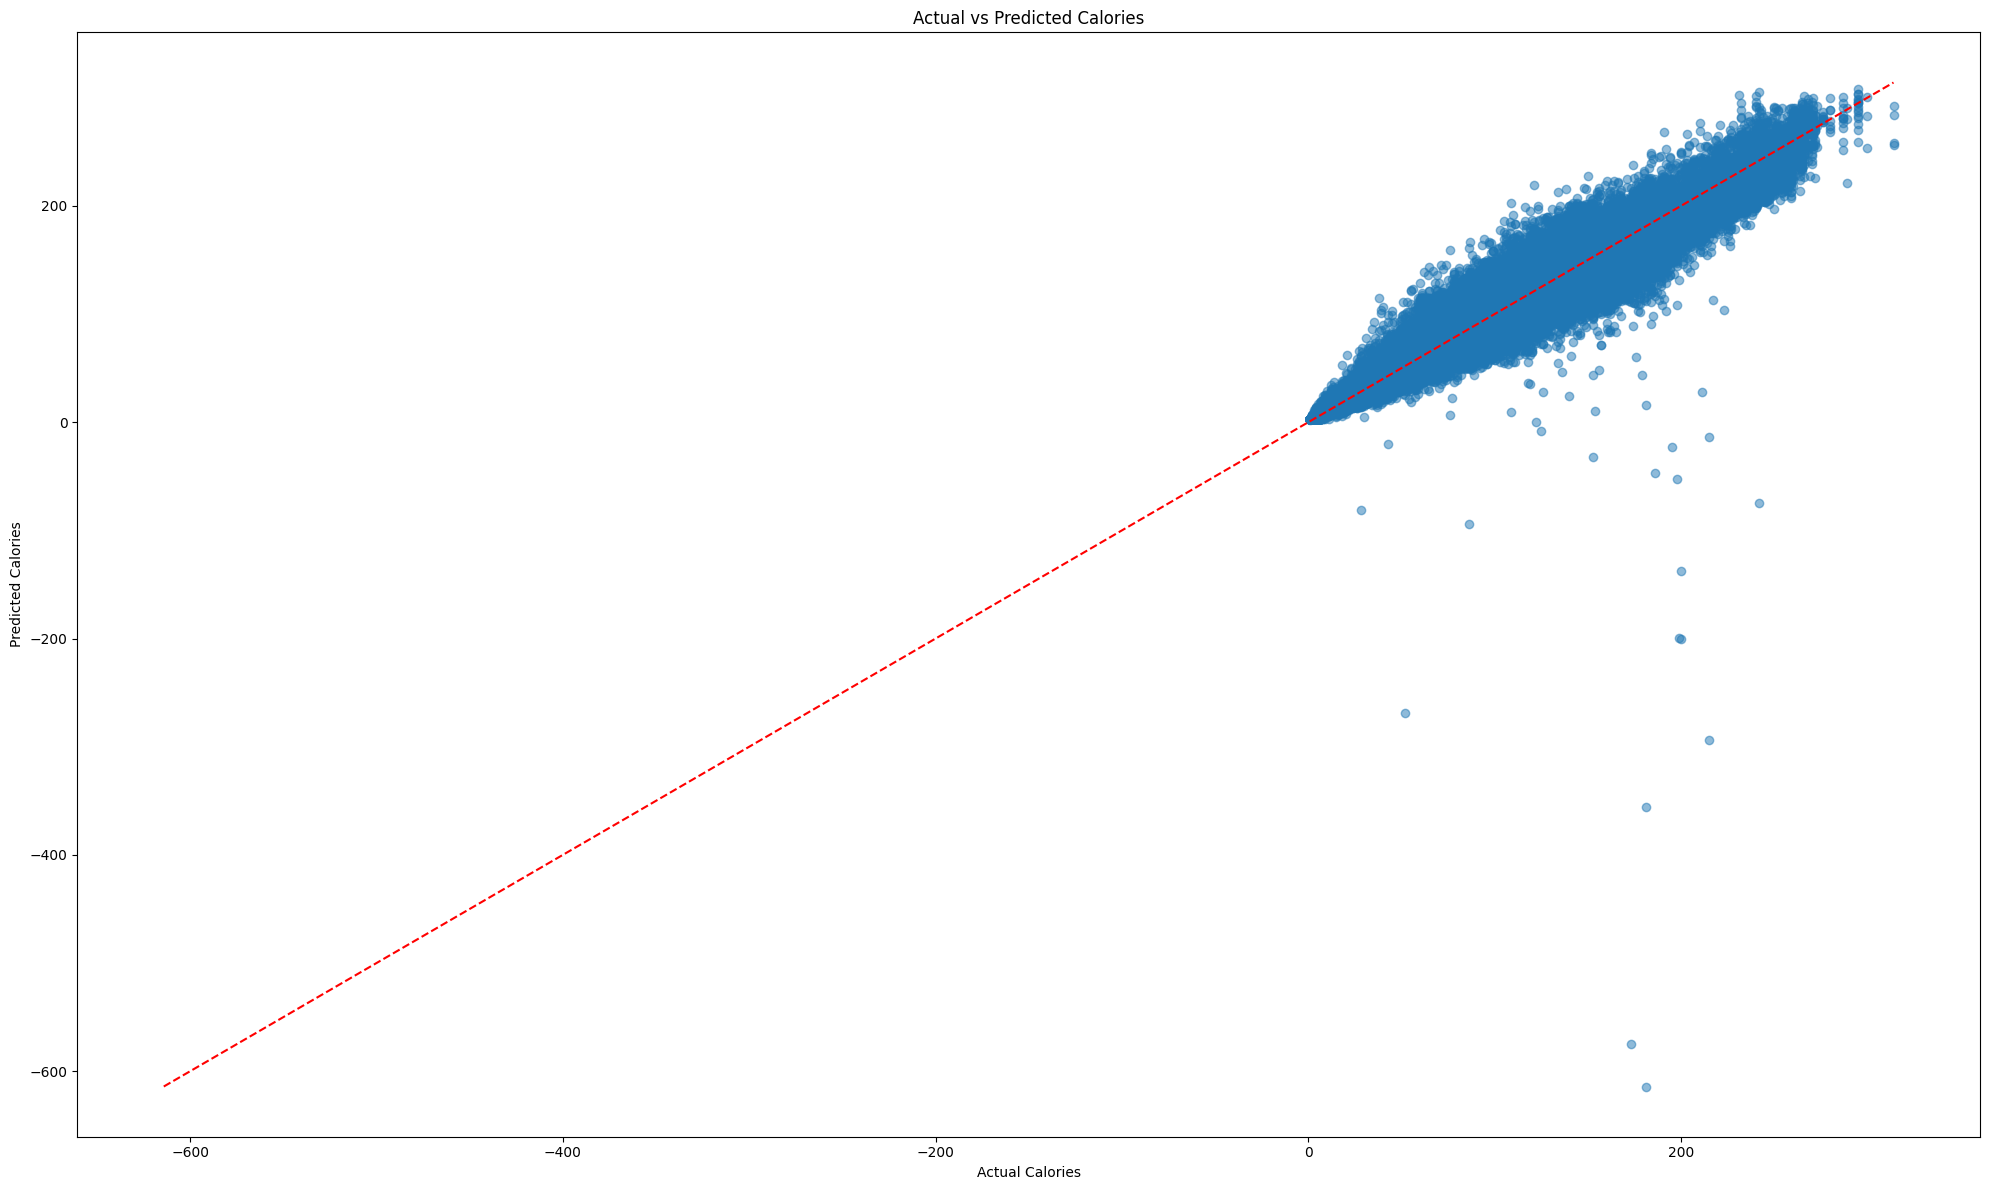

In [63]:
plot_predictions(trained_enhanced_model, X_test_enh, Y_test_enh)

***Creating the Test data submission for kaggle competition***

In [4]:
test_df = pd.read_csv('test.csv',na_filter=False)

In [70]:
def process_test_data(dataframe):
    if dataframe.isna().sum().sum() > 0 or dataframe.isnull().sum().sum() > 0:
        dataframe.dropna
    
    id_df = dataframe['id']
    
    dataframe['BMI'] = dataframe['Weight'] / ((dataframe['Height']/100) ** 2)
    dataframe['Adjusted_HR'] = dataframe['Heart_Rate'] * (37/dataframe['Body_Temp'])
    dataframe['dummy'] = 0
    
    
    numeric_features = ['Age','Height','Weight','Heart_Rate','Body_Temp','BMI','Adjusted_HR','dummy']
    categorical_features = ['Sex']
    
    num_encoder = StandardScaler()
    cat_encoder = OneHotEncoder(drop="first", sparse_output=False)
    
    preprocessor = ColumnTransformer(transformers= [('num', num_encoder, numeric_features),('cat',cat_encoder,categorical_features)])
    
    test_processed = preprocessor.fit_transform(dataframe)
    
    return id_df, test_processed

In [71]:
id_df, test_processed = process_test_data(test_df)

In [20]:
trained_enhanced_model = keras.models.load_model('best_param_model.h5')

In [21]:
test_predictions = trained_enhanced_model.predict(test_processed)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step


In [49]:
test_pred_df = pd.DataFrame(test_predictions, columns=['Calories'])

In [83]:
submission_df = pd.DataFrame()
submission_df['id'] = id_df
submission_df['Calories'] = test_pred_df.iloc[:, 0]

In [86]:
submission_df.to_csv('/home/albatrosfirst/calorieexp_NN/submission.csv')